# **Skin Lesion Segmentation**

## **Connecting Google Drive**

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## **Extracting the Training data**

In [ ]:
# Importing train data from google drive
fid = drive.ListFile({'q':"title='Train_Data.rar'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Train_Data.rar')

In [ ]:
# unzipping the contents of zip folder
!pip install unrar
!unrar x Train_Data

## **Importing the required Libraries**

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 384
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [ ]:
TRAIN_PATH = 'Train_Data/BWT/'
TRAIN_PATH_MASK='Train_Data/MASK/'

In [ ]:
# removing unwanted files 
test = os.listdir(TRAIN_PATH)
for item in test:
    if item.endswith(".ini"):
        os.remove(os.path.join(TRAIN_PATH, item))

In [ ]:
train_ids = next(os.walk(TRAIN_PATH))[2]
train_ids = np.sort(train_ids)
print("No. of images = ", len(train_ids))
#test_ids = next(os.walk(TEST_PATH))[2]
#train_ids = np.delete(train_ids,(0),axis=0)
X = np.zeros((len(train_ids),IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y = np.zeros((len(train_ids),IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

No. of images =  6452


In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    X[n] = img

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
test = os.listdir(TRAIN_PATH_MASK)
for item in test:
    if item.endswith(".ini"):
        os.remove(os.path.join(TRAIN_PATH_MASK, item))

train_mask_ids = next(os.walk(TRAIN_PATH_MASK))[2]
train_mask_ids = np.sort(train_mask_ids)
print("No. of images = ", len(train_mask_ids))    
for n1, id1_ in tqdm_notebook(enumerate(train_mask_ids), total=len(train_mask_ids)):
    mask = img_to_array(load_img("Train_Data/MASK/"+id1_, grayscale=True))
    Y[n1] = mask

No. of images =  6452


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


## **Data spliting for Training and Validation**

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)

## **Random dermoscopic image with its corresponding Segmentation map**

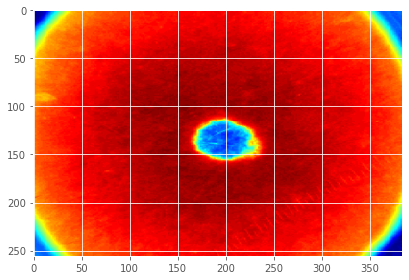

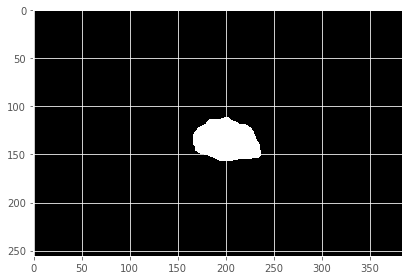

In [ ]:
image_x = random.randint(0, len(train_ids))
imshow(X[image_x])
plt.show()
imshow(np.squeeze(Y[image_x]))
plt.show()

## **Network hidden layers**

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((IMG_HEIGHT,IMG_WIDTH, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

## **Network Structure**

In [ ]:
model.summary()

Model: "functional_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 384, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256, 384, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 256, 384, 16) 0           batch_normalization_19[0][0]     
_______________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-skin-lesion-segmentation.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

## **Network training**

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
162/162 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9542
Epoch 00001: val_loss improved from inf to 0.12847, saving model to model-skin-lesion-segmentation.h5
162/162 [==============================] - 66s 406ms/step - loss: 0.1720 - accuracy: 0.9542 - val_loss: 0.1285 - val_accuracy: 0.9588
Epoch 2/50
162/162 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.9681
Epoch 00002: val_loss improved from 0.12847 to 0.08693, saving model to model-skin-lesion-segmentation.h5
162/162 [==============================] - 65s 400ms/step - loss: 0.0970 - accuracy: 0.9681 - val_loss: 0.0869 - val_accuracy: 0.9703
Epoch 3/50
162/162 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9709
Epoch 00003: val_loss improved from 0.08693 to 0.08025, saving model to model-skin-lesion-segmentation.h5
162/162 [==============================] - 65s 402ms/step - loss: 0.0822 - accuracy: 0.9709 - val_loss: 0.0803 - val_accuracy: 0.9

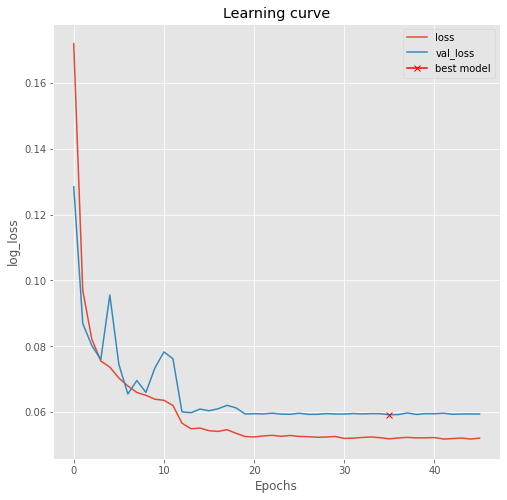

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## **Model Validation on the test data**

In [ ]:
# load the best model after training for testing on test dataset
model.load_weights('model-skin-lesion-segmentation.h5')

In [ ]:
fid = drive.ListFile({'q':"title='PH2.rar'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('PH2.rar')

In [ ]:
#!pip install unrar
!unrar x PH2

In [ ]:
Test_Path='/content/BWT/'
Test_ids = next(os.walk(Test_Path))[2]
Test_ids = np.sort(Test_ids)

test = os.listdir(Test_Path)
for item in test:
    if item.endswith(".ini"):
        os.remove(os.path.join(Test_Path, item))

Test_Mask_Path='/content/MASK/'
Test_Mask_ids = next(os.walk(Test_Mask_Path))[2]
Test_Mask_ids = np.sort(Test_Mask_ids)

print("No. of Test images = ", len(Test_ids))
print("No. of Test Mask images = ", len(Test_Mask_ids))
#test_ids = next(os.walk(TEST_PATH))[2]
#train_ids = np.delete(train_ids,(0),axis=0)
X = np.zeros((len(Test_ids),IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y = np.zeros((len(Test_ids),IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


No. of Test images =  200
No. of Test Mask images =  200


In [ ]:
for n, id_ in tqdm_notebook(enumerate(Test_ids), total=len(Test_ids)):
    path = Test_Path + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    x_img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 3), mode = 'constant', preserve_range = True)
    X[n] = x_img

# tqdm is used to display the progress bar
for n1, id1_ in tqdm_notebook(enumerate(Test_Mask_ids), total=len(Test_Mask_ids)):
     mask = img_to_array(load_img("/content/MASK/"+id1_, grayscale=True))
     mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode = 'constant', preserve_range = True)
     Y[n1] = mask

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


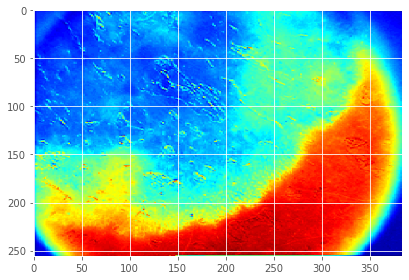

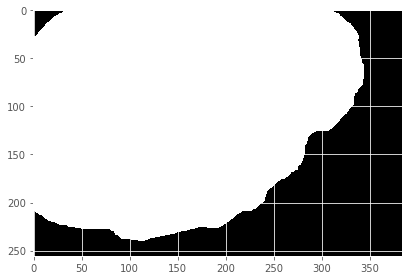

In [ ]:
image_x = random.randint(0, len(Test_ids))
imshow(X[image_x])
plt.show()
imshow(np.squeeze(Y[image_x]))
plt.show()

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X, Y, verbose=1)

7/7 [==============================] - 25s 4s/step - loss: 0.1875 - accuracy: 0.9400


[0.187486469745636, 0.9400370121002197]

In [ ]:
# Predict on test dataset
predicted = model.predict(X, verbose=1)
predicted = (predicted > 0.5).astype(np.bool)

7/7 [==============================] - 25s 4s/step


In [ ]:
def plot_sample(X, y, preds, X1, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(np.squeeze(preds[ix]))
    ax[0].set_title('BWT_Decomposed')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground_Truth')

    ax[2].imshow(preds[ix].squeeze())
   # if has_mask:
    #    ax[2].contour(y[ix].squeeze())
    ax[2].set_title('BWT+UNET Predicted_Mask')
    
    ax[3].imshow(img)
    ax[3].contour(np.squeeze(preds[ix]))
    ax[3].set_title('Border_Detected_Skin_Lesion')

## **Segmentation results**

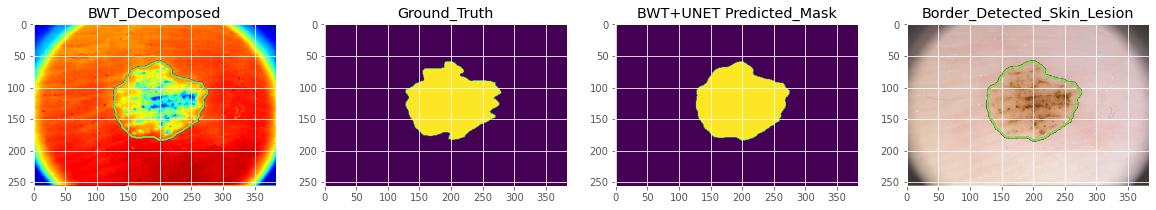

In [ ]:
# Results on 
plot_sample(X, Y, predicted, X1, ix= 4)

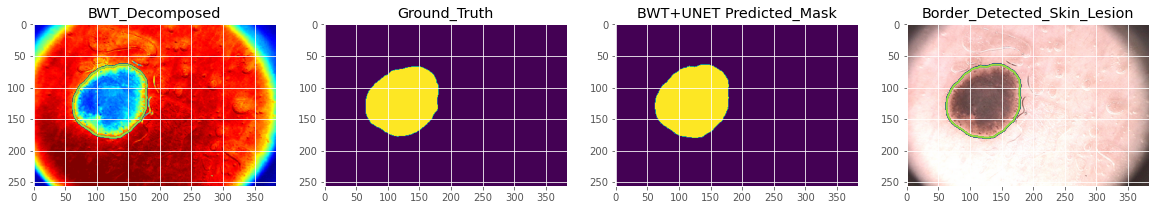

In [ ]:
plot_sample(X, Y, predicted, X1, ix= 13)

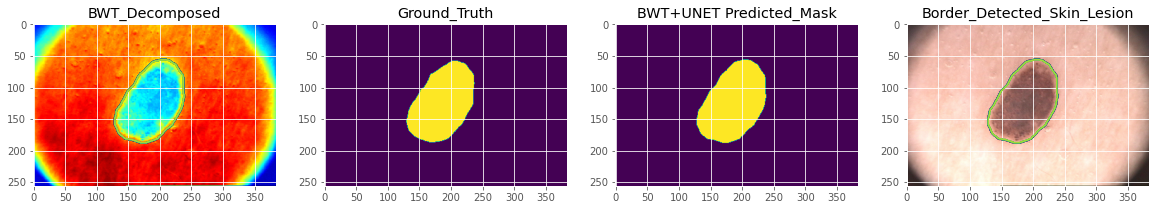

In [ ]:
plot_sample(X, Y, predicted, X1, ix= 12)

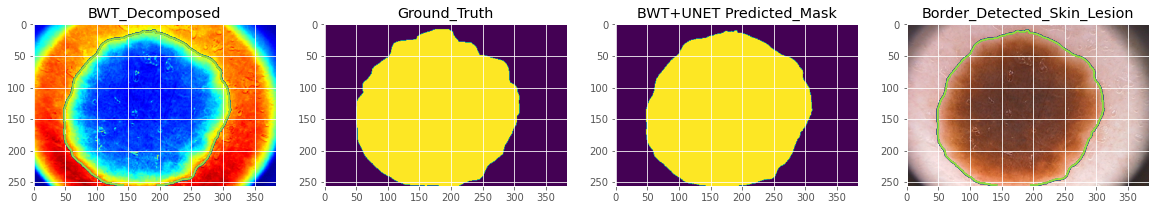

In [ ]:
plot_sample(X, Y, predicted, X1, ix= 11)

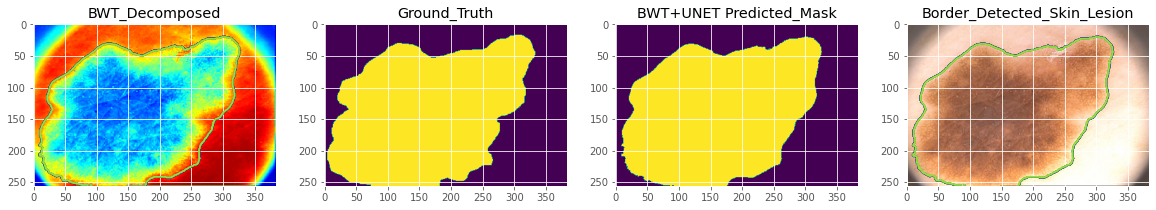

In [ ]:
plot_sample(X, Y, predicted, X1, ix= 198)

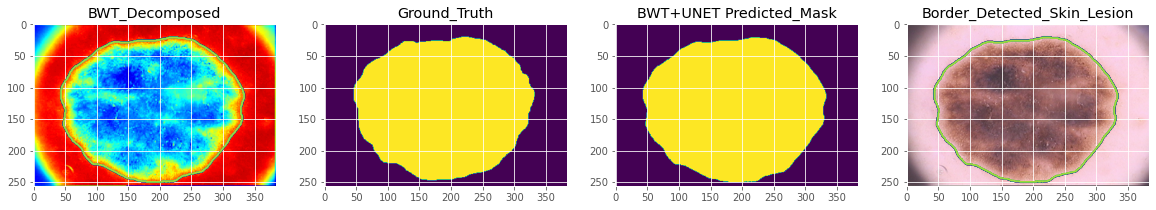

In [ ]:
plot_sample(X, Y, predicted, X1, ix= 199)

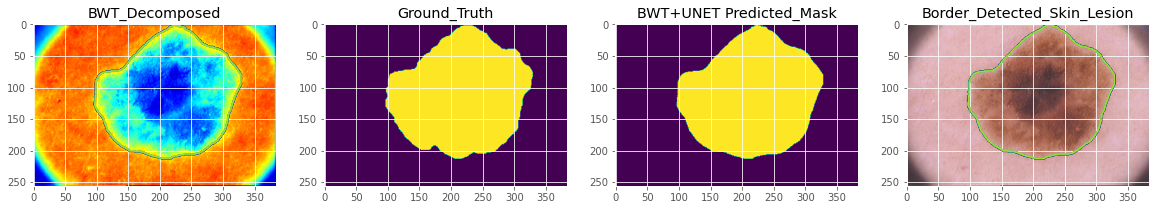

In [ ]:
plot_sample(X, Y, predicted, X1, ix= 190)